# Randomly subsample genome

How does accuracy vary with genome completeness, for each condition/model?

Data:

- 10 genomes for each condition
- Even spacing across predicted values
- Identified in another notebook



How does subsampling work?
- Takes random % of each contig
- Take random % of proteins


In [1]:
df['phylum']

NameError: name 'df' is not defined

In [17]:
import datetime
import sys
from pathlib import Path
import json 
import matplotlib.pyplot as plt
import string
from glob import glob
import numpy as np
import pandas as pd
import sys
sys.path.append("../")
from genome_spot.helpers import rename_condition_to_variable, load_train_and_test_sets
from genome_spot.genome_spot import GenomeSPOT
from genome_spot.bioinformatics.genome import measure_genome_features
ROOT_DIR = str(Path().resolve().parent)
plt.rcParams['svg.fonttype'] = 'none'

sys.path.append('../')
plt.style.use(f'{ROOT_DIR}/notebooks/project.mplstyle')

units = {
    'temperature' : u'\N{DEGREE SIGN}C',
    'ph' : 'pH',
    'salinity' : '% NaCl',
    'oxygen' : 'Prob.'
}

plot_formats = {
    'oxygen' : 'Oxygen',
    'temperature' : 'Temperature',
    'ph' : 'pH',
    'salinity' : 'Salinity',
    'temperature_optimum' : 'Temperature, Optimum ',
    'ph_optimum' : 'pH, Optimum',
    'salinity_optimum' : 'Salinity, Optimum',
    'temperature_min' : 'Temperature, Minimum',
    'salinity_min' : 'Salinity, Minimum',
    'ph_min' : 'pH, Minimum',
    'temperature_max' : 'Temperature, Maximum',
    'salinity_max' : 'Salinity, Maximum',
    'ph_max' : 'pH, Maximum',
}
measure_genome_features?

Signature: measure_genome_features(faa_path: str, fna_path: str, subsample=1.0) -> Dict[str, dict]
Docstring: Measure features from the provided genome files
File:      ~/cultivarium/predict-media-physicochemistry/venv_physicochemistry/lib/python3.8/site-packages/genome_spot/bioinformatics/genome.py
Type:      function

## Get genomes to test

In [2]:
# from collections import defaultdict
# PATH_TO_HOLDOUTS = '../data/holdouts/'

# sers = []
# for tsv in glob(f"../data/predictions/*.predictions.tsv"):
#     try:
#         predictions_df = pd.read_csv(tsv, sep='\t', index_col=0)
#         accession = tsv.split('/')[-1][:-len('.predictions.tsv')]
#         ser = predictions_df['value']
#         ser.name = accession
#         sers.append(ser)
#     except:
#         pass

# predictions_df = pd.concat(sers,axis=1).T

# genomes_to_test = defaultdict(list)
# conditions = [ 'oxygen', 'temperature', 'salinity', 'ph', ]
# for condition in conditions:
#     target = rename_condition_to_variable(condition)
#     train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
#     X = predictions_df.reindex(train_set)[target].dropna()
#     value_bounds = [value for value in np.linspace(X.min(), X.max(),10)]
#     #for value in np.linspace(X.min(),X.max(),20):
#     print(np.percentile(X, [int(i) for i in np.linspace(0, 100, 20)]))
#     for value in np.percentile(X, [int(i) for i in np.linspace(0, 100, 20)]):
#         closest_index = X.index[np.argmin(np.abs(X - value))]
#         genomes_to_test[target].append(closest_index)

# predictions_df

ValueError: No objects to concatenate

In [2]:
# Fixed after finding
genomes_to_test = {'oxygen': ['GCA_004310395',
              'GCA_015163485',
              'GCA_001643775',
              'GCA_003814835',
              'GCA_900115655',
              'GCA_000745975',
              'GCA_013389365',
              'GCA_000373185',
              'GCA_013201705',
              'GCA_001544015',
              'GCA_011927685',
              'GCA_001029435',
              'GCA_900447645',
              'GCA_002163585',
              'GCA_003177275',
              'GCA_014648315',
              'GCA_014643175',
              'GCA_003788585',
              'GCA_014653155',
              'GCA_900660465'],
             'temperature_optimum': ['GCA_014645015',
              'GCA_004340665',
              'GCA_000422265',
              'GCA_003149515',
              'GCA_001043175',
              'GCA_000429845',
              'GCA_014203705',
              'GCA_900105015',
              'GCA_000521505',
              'GCA_014201785',
              'GCA_002925845',
              'GCA_024753215',
              'GCA_008802405',
              'GCA_003696285',
              'GCA_016722785',
              'GCA_000423525',
              'GCA_001462205',
              'GCA_009466385',
              'GCA_001552255',
              'GCA_000017945'],
             'salinity_optimum': ['GCA_000017945',
              'GCA_000429325',
              'GCA_003583925',
              'GCA_003058325',
              'GCA_003284895',
              'GCA_003173715',
              'GCA_016908975',
              'GCA_003012745',
              'GCA_003148665',
              'GCA_007713745',
              'GCA_009811315',
              'GCA_002866825',
              'GCA_001884135',
              'GCA_000423645',
              'GCA_000170835',
              'GCA_014201735',
              'GCA_002216005',
              'GCA_009176545',
              'GCA_900116205',
              'GCA_900104065'],
             'ph_optimum': ['GCA_000258425',
              'GCA_900112405',
              'GCA_001571045',
              'GCA_016865235',
              'GCA_013408745',
              'GCA_000429985',
              'GCA_001613245',
              'GCA_014647975',
              'GCA_008271285',
              'GCA_014653155',
              'GCA_001982615',
              'GCA_014197145',
              'GCA_000974365',
              'GCA_004291315',
              'GCA_003594815',
              'GCA_017873955',
              'GCA_014197055',
              'GCA_003317055',
              'GCA_001562195',
              'GCA_000306965']}

In [4]:
# Check not the same species
from genome_spot.taxonomy.taxonomy import TaxonomyGTDB
taxonomy = TaxonomyGTDB()
taxonomy_dict = taxonomy.taxonomy_dict

from collections import Counter
for target, genomes in genomes_to_test.items():
    species = []
    for genome in genomes:
        species.extend([taxonomy.taxonomy_dict[genome][-1]])
    print([k for k, v in Counter(species).items() if v > 1])

[]
[]
[]
[]


## Subsample

In [6]:
subsample_portions = np.linspace(0.1, 1., 19)
subsample_portions

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [7]:
targets =  [ 'oxygen', 'temperature_optimum', 'temperature_max', 'temperature_min', 'salinity_optimum', 'salinity_max', 'salinity_min', 'ph_optimum', 'ph_max', 'ph_min', ]

In [8]:
subsample_portions

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [12]:

for target, genomes in genomes_to_test.items():
    genomes = genomes_to_test[target]
    for genome in genomes:
        contig_filepath = glob(f"{ROOT_DIR}/data/genomes/genbank/*/*/{genome}.*.fna.gz")[0]
        protein_filepath = glob(f"{ROOT_DIR}/data/genomes/genbank/*/*/{genome}.*.faa.gz")[0]
        prefix = contig_filepath.split('/')[-1].split('.')[0]
    
        print(datetime.datetime.now(), target, genome)
        
        subsample_predictions = {}
        for subsample in subsample_portions[::-1]:
            # try:
            #print(subsample)
            genome_features = measure_genome_features(faa_path=protein_filepath, fna_path=contig_filepath, subsample=subsample)
            predictions = GenomeSPOT().predict_from_genome(genome_features, path_to_models='../models/')
            subsample_predictions[subsample] = {k : d.get('value', np.nan) for k, d in predictions.items()}
            
            # get probabilities for oxygen 
            #{k : d.get('value', np.nan) for k, d in predictions.items()}
            value = predictions.get('oxygen', {}).get('value', '')
            prob = predictions.get('oxygen', {}).get('error', np.nan)
            
            if value == 'tolerant':
                value = prob
            else:
                value = 1 - prob
            subsample_predictions[subsample]['oxygen'] = value
        # except:
            #     print(subsample, 'FAILED')
            #     subsample_predictions[subsample] = {k : np.nan for k in targets}
    
        filepath = f'../data/subsample_experiment/{prefix}.predictions.json'
        json.dump(subsample_predictions, open(filepath, 'w'))

2024-03-19 16:09:26 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_004310395.1/GCA_004310395.1_ASM431039v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_004310395.1/GCA_004310395.1_ASM431039v1_protein.faa.gz
2024-03-19 16:09:26 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Identifying protein localization


2024-03-19 16:09:26.207712 oxygen GCA_004310395


2024-03-19 16:09:26 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:09:27 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:09:27 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_004310395.1/GCA_004310395.1_ASM431039v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_004310395.1/GCA_004310395.1_ASM431039v1_protein.faa.gz
2024-03-19 16:09:27 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:09:27 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:09:27 INFO GCA_004310395.1_ASM431039v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:09:27 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_004310

2024-03-19 16:09:40.440420 oxygen GCA_015163485


2024-03-19 16:09:41 INFO GCA_015163485.1_ASM1516348v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:09:42 INFO GCA_015163485.1_ASM1516348v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:09:42 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_015163485.1/GCA_015163485.1_ASM1516348v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_015163485.1/GCA_015163485.1_ASM1516348v1_protein.faa.gz
2024-03-19 16:09:42 INFO GCA_015163485.1_ASM1516348v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:09:43 INFO GCA_015163485.1_ASM1516348v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:09:43 INFO GCA_015163485.1_ASM1516348v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:09:43 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA

2024-03-19 16:10:04.152867 oxygen GCA_001643775


2024-03-19 16:10:04 INFO GCA_001643775.1_ASM164377v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:10:05 INFO GCA_001643775.1_ASM164377v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:10:05 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001643775.1/GCA_001643775.1_ASM164377v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001643775.1/GCA_001643775.1_ASM164377v1_protein.faa.gz
2024-03-19 16:10:05 INFO GCA_001643775.1_ASM164377v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:10:06 INFO GCA_001643775.1_ASM164377v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:10:06 INFO GCA_001643775.1_ASM164377v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:10:06 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-19 16:10:25.923123 oxygen GCA_003814835


2024-03-19 16:10:26 INFO GCA_003814835.1_ASM381483v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:10:27 INFO GCA_003814835.1_ASM381483v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:10:27 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_003814835.1/GCA_003814835.1_ASM381483v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_003814835.1/GCA_003814835.1_ASM381483v1_protein.faa.gz
2024-03-19 16:10:27 INFO GCA_003814835.1_ASM381483v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:10:27 INFO GCA_003814835.1_ASM381483v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:10:28 INFO GCA_003814835.1_ASM381483v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:10:28 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_003814

2024-03-19 16:10:46.110451 oxygen GCA_900115655


2024-03-19 16:10:47 INFO GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:10:47 INFO GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:10:47 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900115655.1/GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900115655.1/GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_protein.faa.gz
2024-03-19 16:10:47 INFO GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_genomic.fna.gz: Identifying protein localization
2024-03-19 16:10:48 INFO GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:10:49 INFO GCA_900115655.1_IMG-taxon_2595698241_annotated_assembly_

2024-03-19 16:11:13.003106 oxygen GCA_000745975


2024-03-19 16:11:14 INFO GCA_000745975.1_ASM74597v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:11:15 INFO GCA_000745975.1_ASM74597v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:11:15 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000745975.1/GCA_000745975.1_ASM74597v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000745975.1/GCA_000745975.1_ASM74597v1_protein.faa.gz
2024-03-19 16:11:15 INFO GCA_000745975.1_ASM74597v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:11:17 INFO GCA_000745975.1_ASM74597v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:11:18 INFO GCA_000745975.1_ASM74597v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:11:18 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000745975.

2024-03-19 16:11:57.681127 oxygen GCA_013389365


2024-03-19 16:11:59 INFO GCA_013389365.1_ASM1338936v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:12:00 INFO GCA_013389365.1_ASM1338936v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:12:00 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_013389365.1/GCA_013389365.1_ASM1338936v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_013389365.1/GCA_013389365.1_ASM1338936v1_protein.faa.gz
2024-03-19 16:12:00 INFO GCA_013389365.1_ASM1338936v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:12:02 INFO GCA_013389365.1_ASM1338936v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:12:04 INFO GCA_013389365.1_ASM1338936v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:12:04 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:12:45.757457 oxygen GCA_000373185


2024-03-19 16:12:47 INFO GCA_000373185.1_ASM37318v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:12:47 INFO GCA_000373185.1_ASM37318v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:12:47 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000373185.1/GCA_000373185.1_ASM37318v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000373185.1/GCA_000373185.1_ASM37318v1_protein.faa.gz
2024-03-19 16:12:47 INFO GCA_000373185.1_ASM37318v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:12:49 INFO GCA_000373185.1_ASM37318v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:12:49 INFO GCA_000373185.1_ASM37318v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:12:49 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000373185.

2024-03-19 16:13:31.213943 oxygen GCA_013201705


2024-03-19 16:13:33 INFO GCA_013201705.1_ASM1320170v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:13:34 INFO GCA_013201705.1_ASM1320170v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:13:34 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_013201705.1/GCA_013201705.1_ASM1320170v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_013201705.1/GCA_013201705.1_ASM1320170v1_protein.faa.gz
2024-03-19 16:13:34 INFO GCA_013201705.1_ASM1320170v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:13:37 INFO GCA_013201705.1_ASM1320170v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:13:38 INFO GCA_013201705.1_ASM1320170v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:13:38 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:14:28.248589 oxygen GCA_001544015


2024-03-19 16:14:30 INFO GCA_001544015.1_ASM154401v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:14:32 INFO GCA_001544015.1_ASM154401v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:14:32 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001544015.1/GCA_001544015.1_ASM154401v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001544015.1/GCA_001544015.1_ASM154401v1_protein.faa.gz
2024-03-19 16:14:32 INFO GCA_001544015.1_ASM154401v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:14:36 INFO GCA_001544015.1_ASM154401v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:14:37 INFO GCA_001544015.1_ASM154401v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:14:37 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-19 16:15:55.015350 oxygen GCA_011927685


2024-03-19 16:15:58 INFO GCA_011927685.1_ASM1192768v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:16:00 INFO GCA_011927685.1_ASM1192768v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:16:00 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_011927685.1/GCA_011927685.1_ASM1192768v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_011927685.1/GCA_011927685.1_ASM1192768v1_protein.faa.gz
2024-03-19 16:16:00 INFO GCA_011927685.1_ASM1192768v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:16:04 INFO GCA_011927685.1_ASM1192768v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:16:06 INFO GCA_011927685.1_ASM1192768v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:16:06 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:17:31.618439 oxygen GCA_001029435


2024-03-19 16:17:35 INFO GCA_001029435.1_ASM102943v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:17:37 INFO GCA_001029435.1_ASM102943v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:17:38 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001029435.1/GCA_001029435.1_ASM102943v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001029435.1/GCA_001029435.1_ASM102943v1_protein.faa.gz
2024-03-19 16:17:38 INFO GCA_001029435.1_ASM102943v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:17:42 INFO GCA_001029435.1_ASM102943v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:17:44 INFO GCA_001029435.1_ASM102943v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:17:44 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-19 16:18:31.020770 oxygen GCA_900447645


2024-03-19 16:18:32 INFO GCA_900447645.1_39130_A01_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:18:34 INFO GCA_900447645.1_39130_A01_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:18:34 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900447645.1/GCA_900447645.1_39130_A01_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900447645.1/GCA_900447645.1_39130_A01_protein.faa.gz
2024-03-19 16:18:34 INFO GCA_900447645.1_39130_A01_genomic.fna.gz: Identifying protein localization
2024-03-19 16:18:36 INFO GCA_900447645.1_39130_A01_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:18:37 INFO GCA_900447645.1_39130_A01_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:18:37 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900447645.1/GCA_9

2024-03-19 16:19:20.740880 oxygen GCA_002163585


2024-03-19 16:19:22 INFO GCA_002163585.1_ASM216358v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:19:23 INFO GCA_002163585.1_ASM216358v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:19:23 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002163585.1/GCA_002163585.1_ASM216358v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002163585.1/GCA_002163585.1_ASM216358v1_protein.faa.gz
2024-03-19 16:19:23 INFO GCA_002163585.1_ASM216358v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:19:25 INFO GCA_002163585.1_ASM216358v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:19:26 INFO GCA_002163585.1_ASM216358v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:19:26 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002

2024-03-19 16:20:07.750765 oxygen GCA_003177275


2024-03-19 16:20:08 INFO GCA_003177275.1_ASM317727v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:20:09 INFO GCA_003177275.1_ASM317727v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:20:09 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003177275.1/GCA_003177275.1_ASM317727v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003177275.1/GCA_003177275.1_ASM317727v1_protein.faa.gz
2024-03-19 16:20:09 INFO GCA_003177275.1_ASM317727v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:20:10 INFO GCA_003177275.1_ASM317727v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:20:10 INFO GCA_003177275.1_ASM317727v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:20:10 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-19 16:20:34.923183 oxygen GCA_014648315


2024-03-19 16:20:36 INFO GCA_014648315.1_ASM1464831v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:20:37 INFO GCA_014648315.1_ASM1464831v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:20:37 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014648315.1/GCA_014648315.1_ASM1464831v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014648315.1/GCA_014648315.1_ASM1464831v1_protein.faa.gz
2024-03-19 16:20:37 INFO GCA_014648315.1_ASM1464831v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:20:39 INFO GCA_014648315.1_ASM1464831v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:20:40 INFO GCA_014648315.1_ASM1464831v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:20:40 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:21:21.075460 oxygen GCA_014643175


2024-03-19 16:21:22 INFO GCA_014643175.1_ASM1464317v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:21:23 INFO GCA_014643175.1_ASM1464317v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:21:23 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014643175.1/GCA_014643175.1_ASM1464317v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014643175.1/GCA_014643175.1_ASM1464317v1_protein.faa.gz
2024-03-19 16:21:23 INFO GCA_014643175.1_ASM1464317v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:21:24 INFO GCA_014643175.1_ASM1464317v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:21:25 INFO GCA_014643175.1_ASM1464317v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:21:25 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:21:58.547790 oxygen GCA_003788585


2024-03-19 16:21:59 INFO GCA_003788585.1_ASM378858v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:22:00 INFO GCA_003788585.1_ASM378858v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:22:00 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003788585.1/GCA_003788585.1_ASM378858v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003788585.1/GCA_003788585.1_ASM378858v1_protein.faa.gz
2024-03-19 16:22:00 INFO GCA_003788585.1_ASM378858v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:22:01 INFO GCA_003788585.1_ASM378858v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:22:02 INFO GCA_003788585.1_ASM378858v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:22:02 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-19 16:22:31.870652 oxygen GCA_014653155


2024-03-19 16:22:33 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:22:34 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:22:34 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014653155.1/GCA_014653155.1_ASM1465315v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014653155.1/GCA_014653155.1_ASM1465315v1_protein.faa.gz
2024-03-19 16:22:34 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:22:36 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:22:37 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:22:37 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:23:26.802324 oxygen GCA_900660465


2024-03-19 16:23:27 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:23:27 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:23:27 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900660465.1/GCA_900660465.1_50648_A01-3_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900660465.1/GCA_900660465.1_50648_A01-3_protein.faa.gz
2024-03-19 16:23:27 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Identifying protein localization
2024-03-19 16:23:28 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:23:29 INFO GCA_900660465.1_50648_A01-3_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:23:29 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900

2024-03-19 16:23:46.931444 temperature_optimum GCA_014645015


2024-03-19 16:23:49 INFO GCA_014645015.1_ASM1464501v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:23:51 INFO GCA_014645015.1_ASM1464501v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:23:51 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014645015.1/GCA_014645015.1_ASM1464501v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014645015.1/GCA_014645015.1_ASM1464501v1_protein.faa.gz
2024-03-19 16:23:51 INFO GCA_014645015.1_ASM1464501v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:23:54 INFO GCA_014645015.1_ASM1464501v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:23:55 INFO GCA_014645015.1_ASM1464501v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:23:55 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:24:57.598968 temperature_optimum GCA_004340665


2024-03-19 16:25:01 INFO GCA_004340665.1_ASM434066v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:25:04 INFO GCA_004340665.1_ASM434066v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:25:04 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_004340665.1/GCA_004340665.1_ASM434066v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_004340665.1/GCA_004340665.1_ASM434066v1_protein.faa.gz
2024-03-19 16:25:04 INFO GCA_004340665.1_ASM434066v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:25:08 INFO GCA_004340665.1_ASM434066v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:25:10 INFO GCA_004340665.1_ASM434066v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:25:10 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_004

2024-03-19 16:26:14.914374 temperature_optimum GCA_000422265


2024-03-19 16:26:16 INFO GCA_000422265.1_ASM42226v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:26:16 INFO GCA_000422265.1_ASM42226v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:26:16 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000422265.1/GCA_000422265.1_ASM42226v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000422265.1/GCA_000422265.1_ASM42226v1_protein.faa.gz
2024-03-19 16:26:16 INFO GCA_000422265.1_ASM42226v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:26:18 INFO GCA_000422265.1_ASM42226v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:26:18 INFO GCA_000422265.1_ASM42226v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:26:18 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000422265.

2024-03-19 16:26:46.022115 temperature_optimum GCA_003149515


2024-03-19 16:26:48 INFO GCA_003149515.1_ASM314951v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:26:49 INFO GCA_003149515.1_ASM314951v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:26:49 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003149515.1/GCA_003149515.1_ASM314951v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003149515.1/GCA_003149515.1_ASM314951v1_protein.faa.gz
2024-03-19 16:26:49 INFO GCA_003149515.1_ASM314951v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:26:51 INFO GCA_003149515.1_ASM314951v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:26:52 INFO GCA_003149515.1_ASM314951v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:26:52 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-19 16:27:35.664927 temperature_optimum GCA_001043175


2024-03-19 16:27:37 INFO GCA_001043175.1_ASM104317v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:27:38 INFO GCA_001043175.1_ASM104317v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:27:38 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001043175.1/GCA_001043175.1_ASM104317v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001043175.1/GCA_001043175.1_ASM104317v1_protein.faa.gz
2024-03-19 16:27:38 INFO GCA_001043175.1_ASM104317v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:27:39 INFO GCA_001043175.1_ASM104317v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:27:40 INFO GCA_001043175.1_ASM104317v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:27:40 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-19 16:28:16.540267 temperature_optimum GCA_000429845


2024-03-19 16:28:18 INFO GCA_000429845.1_ASM42984v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:28:19 INFO GCA_000429845.1_ASM42984v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:28:19 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429845.1/GCA_000429845.1_ASM42984v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429845.1/GCA_000429845.1_ASM42984v1_protein.faa.gz
2024-03-19 16:28:19 INFO GCA_000429845.1_ASM42984v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:28:21 INFO GCA_000429845.1_ASM42984v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:28:22 INFO GCA_000429845.1_ASM42984v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:28:22 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429845.

2024-03-19 16:29:05.528940 temperature_optimum GCA_014203705


2024-03-19 16:29:09 INFO GCA_014203705.1_ASM1420370v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:29:10 INFO GCA_014203705.1_ASM1420370v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:29:11 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014203705.1/GCA_014203705.1_ASM1420370v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014203705.1/GCA_014203705.1_ASM1420370v1_protein.faa.gz
2024-03-19 16:29:11 INFO GCA_014203705.1_ASM1420370v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:29:14 INFO GCA_014203705.1_ASM1420370v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:29:16 INFO GCA_014203705.1_ASM1420370v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:29:16 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:30:31.531831 temperature_optimum GCA_900105015


2024-03-19 16:30:32 INFO GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:30:32 INFO GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:30:32 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900105015.1/GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900105015.1/GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_protein.faa.gz
2024-03-19 16:30:32 INFO GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_genomic.fna.gz: Identifying protein localization
2024-03-19 16:30:33 INFO GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:30:34 INFO GCA_900105015.1_IMG-taxon_2634166153_annotated_assembly_

2024-03-19 16:30:53.413781 temperature_optimum GCA_000521505


2024-03-19 16:30:55 INFO GCA_000521505.1_ASM52150v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:30:56 INFO GCA_000521505.1_ASM52150v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:30:56 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000521505.1/GCA_000521505.1_ASM52150v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000521505.1/GCA_000521505.1_ASM52150v1_protein.faa.gz
2024-03-19 16:30:56 INFO GCA_000521505.1_ASM52150v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:30:58 INFO GCA_000521505.1_ASM52150v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:30:59 INFO GCA_000521505.1_ASM52150v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:30:59 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000521505.

2024-03-19 16:31:40.914633 temperature_optimum GCA_014201785


2024-03-19 16:31:42 INFO GCA_014201785.1_ASM1420178v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:31:42 INFO GCA_014201785.1_ASM1420178v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:31:42 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014201785.1/GCA_014201785.1_ASM1420178v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014201785.1/GCA_014201785.1_ASM1420178v1_protein.faa.gz
2024-03-19 16:31:42 INFO GCA_014201785.1_ASM1420178v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:31:44 INFO GCA_014201785.1_ASM1420178v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:31:44 INFO GCA_014201785.1_ASM1420178v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:31:45 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:32:14.081042 temperature_optimum GCA_002925845


2024-03-19 16:32:15 INFO GCA_002925845.1_ASM292584v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:32:16 INFO GCA_002925845.1_ASM292584v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:32:16 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002925845.1/GCA_002925845.1_ASM292584v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002925845.1/GCA_002925845.1_ASM292584v1_protein.faa.gz
2024-03-19 16:32:16 INFO GCA_002925845.1_ASM292584v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:32:18 INFO GCA_002925845.1_ASM292584v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:32:19 INFO GCA_002925845.1_ASM292584v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:32:19 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002

2024-03-19 16:32:56.156083 temperature_optimum GCA_024753215


2024-03-19 16:32:58 INFO GCA_024753215.1_ASM2475321v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:32:59 INFO GCA_024753215.1_ASM2475321v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:32:59 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_024753215.1/GCA_024753215.1_ASM2475321v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_024753215.1/GCA_024753215.1_ASM2475321v1_protein.faa.gz
2024-03-19 16:32:59 INFO GCA_024753215.1_ASM2475321v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:33:02 INFO GCA_024753215.1_ASM2475321v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:33:04 INFO GCA_024753215.1_ASM2475321v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:33:04 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:33:49.596636 temperature_optimum GCA_008802405


2024-03-19 16:33:51 INFO GCA_008802405.1_ASM880240v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:33:52 INFO GCA_008802405.1_ASM880240v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:33:52 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_008802405.1/GCA_008802405.1_ASM880240v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_008802405.1/GCA_008802405.1_ASM880240v1_protein.faa.gz
2024-03-19 16:33:52 INFO GCA_008802405.1_ASM880240v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:33:54 INFO GCA_008802405.1_ASM880240v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:33:55 INFO GCA_008802405.1_ASM880240v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:33:55 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_008

2024-03-19 16:34:39.958391 temperature_optimum GCA_003696285


2024-03-19 16:34:41 INFO GCA_003696285.1_ASM369628v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:34:42 INFO GCA_003696285.1_ASM369628v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:34:42 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003696285.1/GCA_003696285.1_ASM369628v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003696285.1/GCA_003696285.1_ASM369628v1_protein.faa.gz
2024-03-19 16:34:42 INFO GCA_003696285.1_ASM369628v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:34:44 INFO GCA_003696285.1_ASM369628v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:34:45 INFO GCA_003696285.1_ASM369628v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:34:45 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-19 16:35:25.364226 temperature_optimum GCA_016722785


2024-03-19 16:35:27 INFO GCA_016722785.1_ASM1672278v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:35:29 INFO GCA_016722785.1_ASM1672278v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:35:29 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_016722785.1/GCA_016722785.1_ASM1672278v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_016722785.1/GCA_016722785.1_ASM1672278v1_protein.faa.gz
2024-03-19 16:35:29 INFO GCA_016722785.1_ASM1672278v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:35:31 INFO GCA_016722785.1_ASM1672278v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:35:33 INFO GCA_016722785.1_ASM1672278v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:35:33 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:36:29.739286 temperature_optimum GCA_000423525


2024-03-19 16:36:30 INFO GCA_000423525.1_ASM42352v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:36:31 INFO GCA_000423525.1_ASM42352v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:36:31 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000423525.1/GCA_000423525.1_ASM42352v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000423525.1/GCA_000423525.1_ASM42352v1_protein.faa.gz
2024-03-19 16:36:31 INFO GCA_000423525.1_ASM42352v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:36:32 INFO GCA_000423525.1_ASM42352v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:36:32 INFO GCA_000423525.1_ASM42352v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:36:32 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000423525.

2024-03-19 16:36:55.750273 temperature_optimum GCA_001462205


2024-03-19 16:36:57 INFO GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:36:57 INFO GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:36:57 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_001462205.1/GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_001462205.1/GCA_001462205.1_HalopeDYS1.0_protein.faa.gz
2024-03-19 16:36:57 INFO GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz: Identifying protein localization
2024-03-19 16:36:59 INFO GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:36:59 INFO GCA_001462205.1_HalopeDYS1.0_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:37:00 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA

2024-03-19 16:37:31.307108 temperature_optimum GCA_009466385


2024-03-19 16:37:32 INFO GCA_009466385.1_ASM946638v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:37:33 INFO GCA_009466385.1_ASM946638v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:37:33 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_009466385.1/GCA_009466385.1_ASM946638v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_009466385.1/GCA_009466385.1_ASM946638v1_protein.faa.gz
2024-03-19 16:37:33 INFO GCA_009466385.1_ASM946638v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:37:34 INFO GCA_009466385.1_ASM946638v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:37:35 INFO GCA_009466385.1_ASM946638v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:37:35 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_009

2024-03-19 16:38:06.985709 temperature_optimum GCA_001552255


2024-03-19 16:38:08 INFO GCA_001552255.1_ASM155225v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:38:09 INFO GCA_001552255.1_ASM155225v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:38:09 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001552255.1/GCA_001552255.1_ASM155225v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001552255.1/GCA_001552255.1_ASM155225v1_protein.faa.gz
2024-03-19 16:38:09 INFO GCA_001552255.1_ASM155225v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:38:10 INFO GCA_001552255.1_ASM155225v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:38:11 INFO GCA_001552255.1_ASM155225v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:38:11 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-19 16:38:47.705682 temperature_optimum GCA_000017945


2024-03-19 16:38:48 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:38:48 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:38:48 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000017945.1/GCA_000017945.1_ASM1794v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000017945.1/GCA_000017945.1_ASM1794v1_protein.faa.gz
2024-03-19 16:38:48 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:38:49 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:38:49 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:38:49 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000017945.1/GCA_0000

2024-03-19 16:39:03.676781 salinity_optimum GCA_000017945


2024-03-19 16:39:04 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:39:04 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:39:04 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000017945.1/GCA_000017945.1_ASM1794v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000017945.1/GCA_000017945.1_ASM1794v1_protein.faa.gz
2024-03-19 16:39:04 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:39:05 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:39:05 INFO GCA_000017945.1_ASM1794v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:39:05 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000017945.1/GCA_0000

2024-03-19 16:39:19.735576 salinity_optimum GCA_000429325


2024-03-19 16:39:21 INFO GCA_000429325.1_ASM42932v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:39:22 INFO GCA_000429325.1_ASM42932v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:39:22 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429325.1/GCA_000429325.1_ASM42932v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429325.1/GCA_000429325.1_ASM42932v1_protein.faa.gz
2024-03-19 16:39:22 INFO GCA_000429325.1_ASM42932v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:39:24 INFO GCA_000429325.1_ASM42932v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:39:25 INFO GCA_000429325.1_ASM42932v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:39:25 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429325.

2024-03-19 16:40:06.939785 salinity_optimum GCA_003583925


2024-03-19 16:40:08 INFO GCA_003583925.1_ASM358392v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:40:09 INFO GCA_003583925.1_ASM358392v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:40:09 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003583925.1/GCA_003583925.1_ASM358392v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003583925.1/GCA_003583925.1_ASM358392v1_protein.faa.gz
2024-03-19 16:40:09 INFO GCA_003583925.1_ASM358392v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:40:11 INFO GCA_003583925.1_ASM358392v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:40:12 INFO GCA_003583925.1_ASM358392v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:40:12 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-19 16:41:04.744045 salinity_optimum GCA_003058325


2024-03-19 16:41:07 INFO GCA_003058325.1_ASM305832v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:41:09 INFO GCA_003058325.1_ASM305832v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:41:09 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003058325.1/GCA_003058325.1_ASM305832v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003058325.1/GCA_003058325.1_ASM305832v1_protein.faa.gz
2024-03-19 16:41:09 INFO GCA_003058325.1_ASM305832v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:41:12 INFO GCA_003058325.1_ASM305832v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:41:14 INFO GCA_003058325.1_ASM305832v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:41:14 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-19 16:42:21.152346 salinity_optimum GCA_003284895


2024-03-19 16:42:22 INFO GCA_003284895.1_ASM328489v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:42:23 INFO GCA_003284895.1_ASM328489v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:42:23 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003284895.1/GCA_003284895.1_ASM328489v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003284895.1/GCA_003284895.1_ASM328489v1_protein.faa.gz
2024-03-19 16:42:23 INFO GCA_003284895.1_ASM328489v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:42:25 INFO GCA_003284895.1_ASM328489v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:42:25 INFO GCA_003284895.1_ASM328489v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:42:26 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-19 16:43:05.063850 salinity_optimum GCA_003173715


2024-03-19 16:43:07 INFO GCA_003173715.1_ASM317371v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:43:09 INFO GCA_003173715.1_ASM317371v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:43:09 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003173715.1/GCA_003173715.1_ASM317371v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003173715.1/GCA_003173715.1_ASM317371v1_protein.faa.gz
2024-03-19 16:43:09 INFO GCA_003173715.1_ASM317371v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:43:11 INFO GCA_003173715.1_ASM317371v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:43:13 INFO GCA_003173715.1_ASM317371v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:43:13 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-19 16:44:07.986571 salinity_optimum GCA_016908975


2024-03-19 16:44:10 INFO GCA_016908975.1_ASM1690897v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:44:12 INFO GCA_016908975.1_ASM1690897v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:44:12 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_016908975.1/GCA_016908975.1_ASM1690897v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_016908975.1/GCA_016908975.1_ASM1690897v1_protein.faa.gz
2024-03-19 16:44:12 INFO GCA_016908975.1_ASM1690897v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:44:14 INFO GCA_016908975.1_ASM1690897v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:44:16 INFO GCA_016908975.1_ASM1690897v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:44:16 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:45:12.712939 salinity_optimum GCA_003012745


2024-03-19 16:45:15 INFO GCA_003012745.1_ASM301274v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:45:16 INFO GCA_003012745.1_ASM301274v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:45:16 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003012745.1/GCA_003012745.1_ASM301274v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003012745.1/GCA_003012745.1_ASM301274v1_protein.faa.gz
2024-03-19 16:45:16 INFO GCA_003012745.1_ASM301274v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:45:19 INFO GCA_003012745.1_ASM301274v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:45:20 INFO GCA_003012745.1_ASM301274v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:45:20 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-19 16:46:15.222728 salinity_optimum GCA_003148665


2024-03-19 16:46:17 INFO GCA_003148665.1_ASM314866v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:46:18 INFO GCA_003148665.1_ASM314866v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:46:18 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003148665.1/GCA_003148665.1_ASM314866v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003148665.1/GCA_003148665.1_ASM314866v1_protein.faa.gz
2024-03-19 16:46:18 INFO GCA_003148665.1_ASM314866v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:46:20 INFO GCA_003148665.1_ASM314866v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:46:21 INFO GCA_003148665.1_ASM314866v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:46:21 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-19 16:47:05.439397 salinity_optimum GCA_007713745


2024-03-19 16:47:08 INFO GCA_007713745.1_ASM771374v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:47:10 INFO GCA_007713745.1_ASM771374v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:47:10 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_007713745.1/GCA_007713745.1_ASM771374v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_007713745.1/GCA_007713745.1_ASM771374v1_protein.faa.gz
2024-03-19 16:47:10 INFO GCA_007713745.1_ASM771374v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:47:13 INFO GCA_007713745.1_ASM771374v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:47:15 INFO GCA_007713745.1_ASM771374v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:47:15 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_007

2024-03-19 16:48:27.243331 salinity_optimum GCA_009811315


2024-03-19 16:48:29 INFO GCA_009811315.1_ASM981131v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:48:30 INFO GCA_009811315.1_ASM981131v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:48:30 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_009811315.1/GCA_009811315.1_ASM981131v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_009811315.1/GCA_009811315.1_ASM981131v1_protein.faa.gz
2024-03-19 16:48:30 INFO GCA_009811315.1_ASM981131v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:48:32 INFO GCA_009811315.1_ASM981131v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:48:33 INFO GCA_009811315.1_ASM981131v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:48:33 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_009

2024-03-19 16:49:15.878652 salinity_optimum GCA_002866825


2024-03-19 16:49:17 INFO GCA_002866825.1_ASM286682v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:49:18 INFO GCA_002866825.1_ASM286682v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:49:18 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002866825.1/GCA_002866825.1_ASM286682v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002866825.1/GCA_002866825.1_ASM286682v1_protein.faa.gz
2024-03-19 16:49:18 INFO GCA_002866825.1_ASM286682v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:49:20 INFO GCA_002866825.1_ASM286682v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:49:21 INFO GCA_002866825.1_ASM286682v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:49:21 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002

2024-03-19 16:50:02.595000 salinity_optimum GCA_001884135


2024-03-19 16:50:04 INFO GCA_001884135.1_ASM188413v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:50:06 INFO GCA_001884135.1_ASM188413v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:50:06 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001884135.1/GCA_001884135.1_ASM188413v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001884135.1/GCA_001884135.1_ASM188413v1_protein.faa.gz
2024-03-19 16:50:06 INFO GCA_001884135.1_ASM188413v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:50:08 INFO GCA_001884135.1_ASM188413v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:50:09 INFO GCA_001884135.1_ASM188413v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:50:09 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-19 16:51:00.462487 salinity_optimum GCA_000423645


2024-03-19 16:51:02 INFO GCA_000423645.1_ASM42364v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:51:02 INFO GCA_000423645.1_ASM42364v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:51:02 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000423645.1/GCA_000423645.1_ASM42364v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000423645.1/GCA_000423645.1_ASM42364v1_protein.faa.gz
2024-03-19 16:51:02 INFO GCA_000423645.1_ASM42364v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:51:04 INFO GCA_000423645.1_ASM42364v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:51:05 INFO GCA_000423645.1_ASM42364v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:51:05 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000423645.

2024-03-19 16:51:39.359618 salinity_optimum GCA_000170835


2024-03-19 16:51:41 INFO GCA_000170835.1_ASM17083v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:51:42 INFO GCA_000170835.1_ASM17083v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:51:42 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000170835.1/GCA_000170835.1_ASM17083v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000170835.1/GCA_000170835.1_ASM17083v1_protein.faa.gz
2024-03-19 16:51:42 INFO GCA_000170835.1_ASM17083v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:51:43 INFO GCA_000170835.1_ASM17083v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:51:44 INFO GCA_000170835.1_ASM17083v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:51:44 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000170835.

2024-03-19 16:52:26.016094 salinity_optimum GCA_014201735


2024-03-19 16:52:27 INFO GCA_014201735.1_ASM1420173v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:52:28 INFO GCA_014201735.1_ASM1420173v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:52:28 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014201735.1/GCA_014201735.1_ASM1420173v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014201735.1/GCA_014201735.1_ASM1420173v1_protein.faa.gz
2024-03-19 16:52:28 INFO GCA_014201735.1_ASM1420173v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:52:30 INFO GCA_014201735.1_ASM1420173v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:52:30 INFO GCA_014201735.1_ASM1420173v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:52:30 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:53:04.997659 salinity_optimum GCA_002216005


2024-03-19 16:53:06 INFO GCA_002216005.1_ASM221600v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:53:06 INFO GCA_002216005.1_ASM221600v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:53:06 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002216005.1/GCA_002216005.1_ASM221600v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002216005.1/GCA_002216005.1_ASM221600v1_protein.faa.gz
2024-03-19 16:53:06 INFO GCA_002216005.1_ASM221600v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:53:08 INFO GCA_002216005.1_ASM221600v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:53:08 INFO GCA_002216005.1_ASM221600v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:53:08 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_002

2024-03-19 16:53:33.205834 salinity_optimum GCA_009176545


2024-03-19 16:53:35 INFO GCA_009176545.1_ASM917654v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:53:36 INFO GCA_009176545.1_ASM917654v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:53:36 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_009176545.1/GCA_009176545.1_ASM917654v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_009176545.1/GCA_009176545.1_ASM917654v1_protein.faa.gz
2024-03-19 16:53:36 INFO GCA_009176545.1_ASM917654v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:53:38 INFO GCA_009176545.1_ASM917654v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:53:39 INFO GCA_009176545.1_ASM917654v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:53:39 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_009176

2024-03-19 16:54:22.812254 salinity_optimum GCA_900116205


2024-03-19 16:54:24 INFO GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:54:25 INFO GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:54:25 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_900116205.1/GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_900116205.1/GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_protein.faa.gz
2024-03-19 16:54:25 INFO GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_genomic.fna.gz: Identifying protein localization
2024-03-19 16:54:27 INFO GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:54:28 INFO GCA_900116205.1_IMG-taxon_2639762563_annotated_assembly_ge

2024-03-19 16:55:06.504081 salinity_optimum GCA_900104065


2024-03-19 16:55:08 INFO GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:55:09 INFO GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:55:09 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_900104065.1/GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_900104065.1/GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_protein.faa.gz
2024-03-19 16:55:09 INFO GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_genomic.fna.gz: Identifying protein localization
2024-03-19 16:55:11 INFO GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:55:12 INFO GCA_900104065.1_IMG-taxon_2636416047_annotated_assembly_ge

2024-03-19 16:55:50.872870 ph_optimum GCA_000258425


2024-03-19 16:55:51 INFO GCA_000258425.1_ASM25842v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:55:51 INFO GCA_000258425.1_ASM25842v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:55:51 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000258425.1/GCA_000258425.1_ASM25842v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000258425.1/GCA_000258425.1_ASM25842v1_protein.faa.gz
2024-03-19 16:55:51 INFO GCA_000258425.1_ASM25842v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:55:52 INFO GCA_000258425.1_ASM25842v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:55:52 INFO GCA_000258425.1_ASM25842v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:55:52 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/archaea/GCA_000258425.1/G

2024-03-19 16:56:06.225728 ph_optimum GCA_900112405


2024-03-19 16:56:06 INFO GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:56:07 INFO GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:56:07 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900112405.1/GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_900112405.1/GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_protein.faa.gz
2024-03-19 16:56:07 INFO GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_genomic.fna.gz: Identifying protein localization
2024-03-19 16:56:07 INFO GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:56:07 INFO GCA_900112405.1_IMG-taxon_2603880187_annotated_assembly_

2024-03-19 16:56:20.684347 ph_optimum GCA_001571045


2024-03-19 16:56:21 INFO GCA_001571045.1_ASM157104v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:56:22 INFO GCA_001571045.1_ASM157104v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:56:22 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001571045.1/GCA_001571045.1_ASM157104v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001571045.1/GCA_001571045.1_ASM157104v1_protein.faa.gz
2024-03-19 16:56:22 INFO GCA_001571045.1_ASM157104v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:56:23 INFO GCA_001571045.1_ASM157104v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:56:24 INFO GCA_001571045.1_ASM157104v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:56:24 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-19 16:56:52.383910 ph_optimum GCA_016865235


2024-03-19 16:56:54 INFO GCA_016865235.1_ASM1686523v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:56:55 INFO GCA_016865235.1_ASM1686523v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:56:55 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_016865235.1/GCA_016865235.1_ASM1686523v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_016865235.1/GCA_016865235.1_ASM1686523v1_protein.faa.gz
2024-03-19 16:56:55 INFO GCA_016865235.1_ASM1686523v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:56:57 INFO GCA_016865235.1_ASM1686523v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:56:58 INFO GCA_016865235.1_ASM1686523v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:56:58 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:57:39.609446 ph_optimum GCA_013408745


2024-03-19 16:57:41 INFO GCA_013408745.1_ASM1340874v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:57:42 INFO GCA_013408745.1_ASM1340874v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:57:42 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_013408745.1/GCA_013408745.1_ASM1340874v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_013408745.1/GCA_013408745.1_ASM1340874v1_protein.faa.gz
2024-03-19 16:57:42 INFO GCA_013408745.1_ASM1340874v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:57:44 INFO GCA_013408745.1_ASM1340874v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:57:45 INFO GCA_013408745.1_ASM1340874v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:57:45 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 16:58:22.759735 ph_optimum GCA_000429985


2024-03-19 16:58:24 INFO GCA_000429985.1_ASM42998v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:58:25 INFO GCA_000429985.1_ASM42998v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:58:25 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429985.1/GCA_000429985.1_ASM42998v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429985.1/GCA_000429985.1_ASM42998v1_protein.faa.gz
2024-03-19 16:58:25 INFO GCA_000429985.1_ASM42998v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:58:26 INFO GCA_000429985.1_ASM42998v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:58:27 INFO GCA_000429985.1_ASM42998v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:58:27 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000429985.

2024-03-19 16:59:02.277782 ph_optimum GCA_001613245


2024-03-19 16:59:05 INFO GCA_001613245.1_ASM161324v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:59:06 INFO GCA_001613245.1_ASM161324v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:59:07 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001613245.1/GCA_001613245.1_ASM161324v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001613245.1/GCA_001613245.1_ASM161324v1_protein.faa.gz
2024-03-19 16:59:07 INFO GCA_001613245.1_ASM161324v1_genomic.fna.gz: Identifying protein localization
2024-03-19 16:59:10 INFO GCA_001613245.1_ASM161324v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 16:59:11 INFO GCA_001613245.1_ASM161324v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 16:59:11 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-19 17:00:17.606841 ph_optimum GCA_014647975


2024-03-19 17:00:21 INFO GCA_014647975.1_ASM1464797v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:00:23 INFO GCA_014647975.1_ASM1464797v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:00:23 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014647975.1/GCA_014647975.1_ASM1464797v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014647975.1/GCA_014647975.1_ASM1464797v1_protein.faa.gz
2024-03-19 17:00:23 INFO GCA_014647975.1_ASM1464797v1_genomic.fna.gz: Identifying protein localization
2024-03-19 17:00:27 INFO GCA_014647975.1_ASM1464797v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:00:29 INFO GCA_014647975.1_ASM1464797v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:00:29 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 17:01:53.731965 ph_optimum GCA_008271285


2024-03-19 17:01:55 INFO GCA_008271285.1_ASM827128v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:01:56 INFO GCA_008271285.1_ASM827128v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:01:56 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_008271285.1/GCA_008271285.1_ASM827128v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_008271285.1/GCA_008271285.1_ASM827128v1_protein.faa.gz
2024-03-19 17:01:56 INFO GCA_008271285.1_ASM827128v1_genomic.fna.gz: Identifying protein localization
2024-03-19 17:01:58 INFO GCA_008271285.1_ASM827128v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:01:59 INFO GCA_008271285.1_ASM827128v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:01:59 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_008

2024-03-19 17:02:41.732589 ph_optimum GCA_014653155


2024-03-19 17:02:43 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:02:44 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:02:44 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014653155.1/GCA_014653155.1_ASM1465315v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014653155.1/GCA_014653155.1_ASM1465315v1_protein.faa.gz
2024-03-19 17:02:44 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Identifying protein localization
2024-03-19 17:02:45 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:02:46 INFO GCA_014653155.1_ASM1465315v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:02:46 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 17:03:23.933032 ph_optimum GCA_001982615


2024-03-19 17:03:26 INFO GCA_001982615.1_ASM198261v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:03:27 INFO GCA_001982615.1_ASM198261v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:03:27 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001982615.1/GCA_001982615.1_ASM198261v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001982615.1/GCA_001982615.1_ASM198261v1_protein.faa.gz
2024-03-19 17:03:27 INFO GCA_001982615.1_ASM198261v1_genomic.fna.gz: Identifying protein localization
2024-03-19 17:03:30 INFO GCA_001982615.1_ASM198261v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:03:31 INFO GCA_001982615.1_ASM198261v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:03:31 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-19 17:04:26.691397 ph_optimum GCA_014197145


2024-03-19 17:04:28 INFO GCA_014197145.1_ASM1419714v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:04:29 INFO GCA_014197145.1_ASM1419714v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:04:29 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014197145.1/GCA_014197145.1_ASM1419714v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014197145.1/GCA_014197145.1_ASM1419714v1_protein.faa.gz
2024-03-19 17:04:29 INFO GCA_014197145.1_ASM1419714v1_genomic.fna.gz: Identifying protein localization
2024-03-19 17:04:31 INFO GCA_014197145.1_ASM1419714v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:04:32 INFO GCA_014197145.1_ASM1419714v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:04:32 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 17:05:16.665512 ph_optimum GCA_000974365


2024-03-19 17:05:18 INFO GCA_000974365.1_ASM97436v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:05:19 INFO GCA_000974365.1_ASM97436v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:05:19 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000974365.1/GCA_000974365.1_ASM97436v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000974365.1/GCA_000974365.1_ASM97436v1_protein.faa.gz
2024-03-19 17:05:19 INFO GCA_000974365.1_ASM97436v1_genomic.fna.gz: Identifying protein localization
2024-03-19 17:05:21 INFO GCA_000974365.1_ASM97436v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:05:22 INFO GCA_000974365.1_ASM97436v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:05:22 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000974365.

2024-03-19 17:06:05.631724 ph_optimum GCA_004291315


2024-03-19 17:06:08 INFO GCA_004291315.1_ASM429131v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:06:10 INFO GCA_004291315.1_ASM429131v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:06:10 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_004291315.1/GCA_004291315.1_ASM429131v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_004291315.1/GCA_004291315.1_ASM429131v1_protein.faa.gz
2024-03-19 17:06:10 INFO GCA_004291315.1_ASM429131v1_genomic.fna.gz: Identifying protein localization
2024-03-19 17:06:12 INFO GCA_004291315.1_ASM429131v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:06:14 INFO GCA_004291315.1_ASM429131v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:06:14 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_004

2024-03-19 17:07:16.807588 ph_optimum GCA_003594815


2024-03-19 17:07:18 INFO GCA_003594815.1_ASM359481v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:07:19 INFO GCA_003594815.1_ASM359481v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:07:19 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003594815.1/GCA_003594815.1_ASM359481v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003594815.1/GCA_003594815.1_ASM359481v1_protein.faa.gz
2024-03-19 17:07:19 INFO GCA_003594815.1_ASM359481v1_genomic.fna.gz: Identifying protein localization
2024-03-19 17:07:20 INFO GCA_003594815.1_ASM359481v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:07:21 INFO GCA_003594815.1_ASM359481v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:07:21 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-19 17:07:56.566173 ph_optimum GCA_017873955


2024-03-19 17:07:57 INFO GCA_017873955.1_ASM1787395v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:07:58 INFO GCA_017873955.1_ASM1787395v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:07:58 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_017873955.1/GCA_017873955.1_ASM1787395v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_017873955.1/GCA_017873955.1_ASM1787395v1_protein.faa.gz
2024-03-19 17:07:58 INFO GCA_017873955.1_ASM1787395v1_genomic.fna.gz: Identifying protein localization
2024-03-19 17:08:00 INFO GCA_017873955.1_ASM1787395v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:08:00 INFO GCA_017873955.1_ASM1787395v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:08:01 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 17:08:33.066162 ph_optimum GCA_014197055


2024-03-19 17:08:34 INFO GCA_014197055.1_ASM1419705v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:08:35 INFO GCA_014197055.1_ASM1419705v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:08:35 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014197055.1/GCA_014197055.1_ASM1419705v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_014197055.1/GCA_014197055.1_ASM1419705v1_protein.faa.gz
2024-03-19 17:08:35 INFO GCA_014197055.1_ASM1419705v1_genomic.fna.gz: Identifying protein localization
2024-03-19 17:08:37 INFO GCA_014197055.1_ASM1419705v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:08:37 INFO GCA_014197055.1_ASM1419705v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:08:37 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/

2024-03-19 17:09:13.274812 ph_optimum GCA_003317055


2024-03-19 17:09:14 INFO GCA_003317055.1_ASM331705v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:09:15 INFO GCA_003317055.1_ASM331705v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:09:15 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003317055.1/GCA_003317055.1_ASM331705v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003317055.1/GCA_003317055.1_ASM331705v1_protein.faa.gz
2024-03-19 17:09:15 INFO GCA_003317055.1_ASM331705v1_genomic.fna.gz: Identifying protein localization
2024-03-19 17:09:16 INFO GCA_003317055.1_ASM331705v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:09:17 INFO GCA_003317055.1_ASM331705v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:09:17 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_003

2024-03-19 17:09:44.981032 ph_optimum GCA_001562195


2024-03-19 17:09:46 INFO GCA_001562195.1_ASM156219v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:09:47 INFO GCA_001562195.1_ASM156219v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:09:47 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001562195.1/GCA_001562195.1_ASM156219v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001562195.1/GCA_001562195.1_ASM156219v1_protein.faa.gz
2024-03-19 17:09:47 INFO GCA_001562195.1_ASM156219v1_genomic.fna.gz: Identifying protein localization
2024-03-19 17:09:49 INFO GCA_001562195.1_ASM156219v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:09:50 INFO GCA_001562195.1_ASM156219v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:09:50 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_001

2024-03-19 17:10:29.412526 ph_optimum GCA_000306965


2024-03-19 17:10:30 INFO GCA_000306965.1_ASM30696v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:10:31 INFO GCA_000306965.1_ASM30696v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:10:31 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000306965.1/GCA_000306965.1_ASM30696v1_genomic.fna.gz
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000306965.1/GCA_000306965.1_ASM30696v1_protein.faa.gz
2024-03-19 17:10:31 INFO GCA_000306965.1_ASM30696v1_genomic.fna.gz: Identifying protein localization
2024-03-19 17:10:33 INFO GCA_000306965.1_ASM30696v1_genomic.fna.gz: Collecting genome statistics
2024-03-19 17:10:34 INFO GCA_000306965.1_ASM30696v1_genomic.fna.gz: Collecting protein statistics
2024-03-19 17:10:34 INFO Measuring features from:
	/Users/tylerbarnum/cultivarium/predict-media-physicochemistry/data/genomes/genbank/bacteria/GCA_000306965.

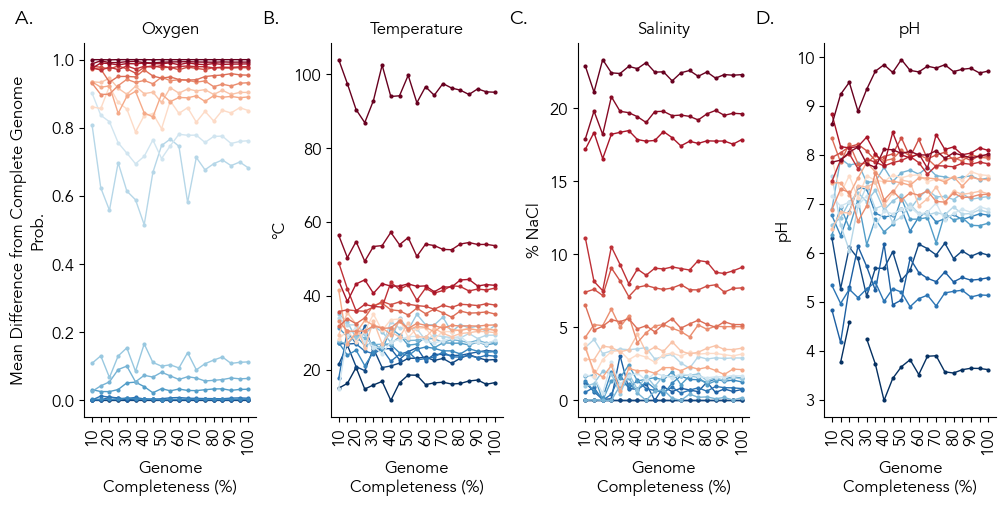

In [23]:
import matplotlib.pyplot as plt
N = 20

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.RdBu_r(np.array(list(np.linspace(0,0.4,int(N/2))) + list(np.linspace(0.6,1,int(N/2))))))
targets =  [ 'oxygen', 'temperature_optimum', 'temperature_max', 'temperature_min', 'salinity_optimum', 'salinity_max', 'salinity_min', 'ph_optimum', 'ph_max', 'ph_min', ]
fig, axes = plt.subplots(1,4, figsize=(10,5))
axl = axes.flatten()
for n, condition in enumerate(['oxygen', 'temperature', 'salinity', 'ph']):
    target = rename_condition_to_variable(condition)
    genomes = genomes_to_test[target]
    ax = axl[n]
    for genome in genomes:
        filepath = glob(f"{ROOT_DIR}/data/subsample_experiment/{genome}*.predictions.json")[0]
        subsample_predictions = json.loads(open(filepath, 'r').read())


        if condition == 'oxygen':
            target = condition
        else:
            target = condition + '_optimum'

        data = pd.DataFrame(subsample_predictions)                

        Y = data.loc[target]
        X = 100 * subsample_portions[::-1]
        ax.plot(X, Y, label=genome, marker='o', markersize=2)
            
    #ax.legend(bbox_to_anchor=(1,1))
    
    ax.set_title(plot_formats[condition])
    ax.set_xticks(X)
    ax.set_xticklabels([f"{int(x)}" if n % 2 == 0 else '' for n, x in enumerate(X) ], rotation=90)
    ax.set_xlabel('Genome\nCompleteness (%)')
    if n == 0:
        ax.set_ylabel(f'Mean Difference from Complete Genome\n{units[condition]}')
    else:
        ax.set_ylabel(f'{units[condition]}')
    ax.text(-0.4, 1.05, f"{string.ascii_uppercase[n]}.", transform=ax.transAxes,  size=14)
plt.tight_layout(pad=0.4)

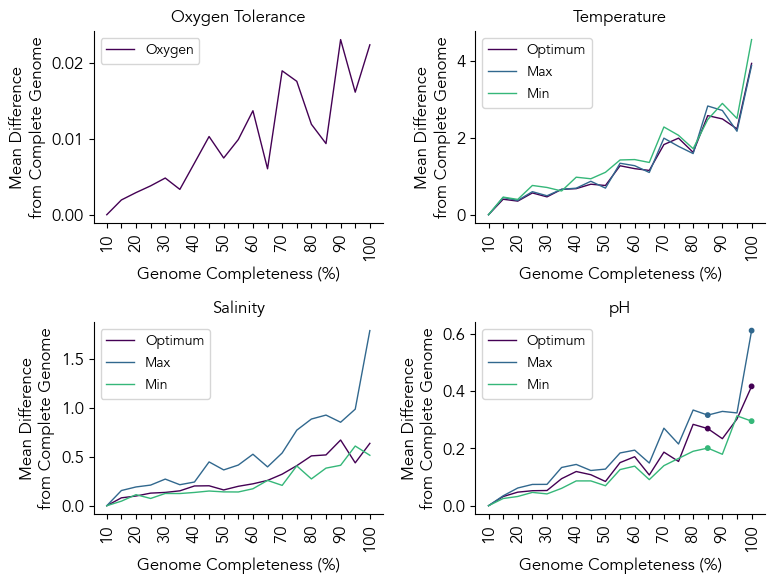

In [15]:
plot_formats = {
    'oxygen' : 'Oxygen Tolerance',
    'temperature' : 'Temperature',
    'ph' : 'pH',
    'salinity' : 'Salinity',
    'temperature_optimum' : 'Temperature, Optimum ',
    'ph_optimum' : 'pH, Optimum',
    'salinity_optimum' : 'Salinity, Optimum',
}


import matplotlib.pyplot as plt
N = 4
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))

targets =  [ 'oxygen', 'temperature_optimum', 'temperature_max', 'temperature_min', 'salinity_optimum', 'salinity_max', 'salinity_min', 'ph_optimum', 'ph_max', 'ph_min', ]

fig, axes = plt.subplots(2,2, figsize=(8,6))
axl = axes.flatten()
for n, condition in enumerate(['oxygen', 'temperature', 'salinity', 'ph']):
#for condition, genomes in genomes_to_test.items():
    target = rename_condition_to_variable(condition)
    genomes = genomes_to_test[target]
    ax = axl[n]
    for target in targets:
        
        if condition in target:
            
            diffs = []
            for genome in genomes:
                filepath = glob(f"{ROOT_DIR}/data/subsample_experiment/{genome}*.predictions.json")[0]
                subsample_predictions = json.loads(open(filepath, 'r').read())
                #print(genome)
                data = pd.DataFrame(subsample_predictions)                
                diff = np.abs(data.loc[target] - data.loc[target, '1.0'])
                diffs.append(diff)

            diffs = np.array(diffs)
            Y = np.nanmean(diffs, axis=0)
            X = 100 * subsample_portions

            S = (0 + 10 * np.sum(np.isnan(diffs),axis=0)) 
            ax.plot(X, Y, label=target.split('_')[-1].capitalize())
            ax.scatter(X, Y, s=S, clip_on=False)
                    
    ax.legend(fontsize=10)
    ax.set_title(plot_formats[condition])
    ax.set_xticks(X)
    ax.set_xticklabels([f"{int(x)}" if n % 2 == 0 else '' for n, x in enumerate(X) ], rotation=90)
    ax.set_xlabel('Genome Completeness (%)')
    ax.set_ylabel('Mean Difference\nfrom Complete Genome')

plt.tight_layout()

0.023062740688610882
3.9373974148440203
0.6694276454182769
0.4168199669172661


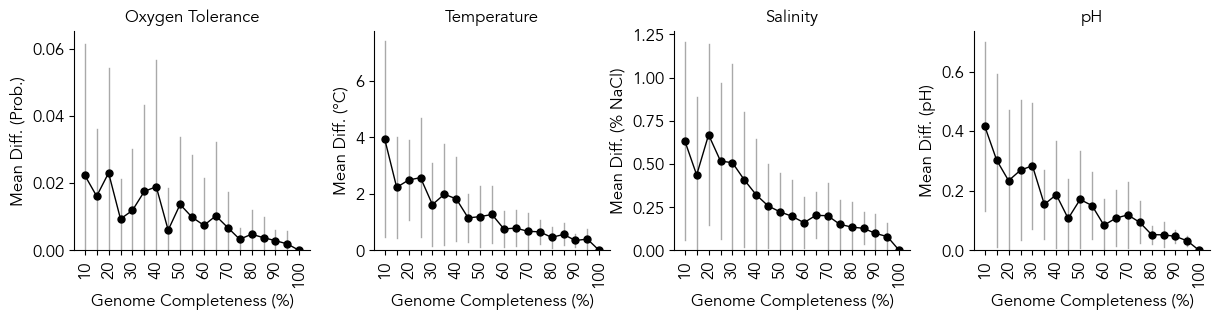

In [16]:

targets = ['oxygen', 'temperature_optimum', 'salinity_optimum', 'ph_optimum']

import matplotlib.pyplot as plt
N = 4
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))

fig, axes = plt.subplots(1,4, figsize=(12,3))
axl = axes.flatten()
for n, condition in enumerate(['oxygen', 'temperature', 'salinity', 'ph']):
    target = rename_condition_to_variable(condition)
    genomes = genomes_to_test[target]
    
    ax = axl[n]
    for target in targets:
        
        if condition in target:
            
            diffs = []
            for genome in genomes:
                filepath = glob(f"{ROOT_DIR}/data/subsample_experiment/{genome}*.predictions.json")[0]
                subsample_predictions = json.loads(open(filepath, 'r').read())
                #print(genome)
                data = pd.DataFrame(subsample_predictions)                
                diff = np.abs(data.loc[target] - data.loc[target, '1.0'])
                diffs.append(diff)

            diffs = np.array(diffs)
            Yerr = np.nanstd(diffs, axis=0) #/ np.nanmean(diffs, axis=0)
            Y = np.nanmean(diffs, axis=0)
            X = 100 * subsample_portions[::-1]
            print(Y.max())

            S = (0 + 10 * np.sum(np.isnan(diffs),axis=0)) 
            ax.plot(X, Y,  marker='.', color='black')
            #ax.errorbar(X, Y, Yerr, marker='.', color='black')
            #ax.scatter(X, Y, s=S, clip_on=False)
            for x, y, yerr in zip(X, Y, Yerr):
                ax.plot([x,x], [y-yerr, y+yerr], color='darkgray', zorder=0, lw=1, clip_on=True)
                    
            ax.set_title(plot_formats[condition])
    ax.set_xticks(X)
    ax.set_xticklabels([f"{int(x)}" if n % 2 == 0 else '' for n, x in enumerate(X) ], rotation=90)
    ax.set_xlabel('Genome Completeness (%)')
    #if n == 0:
    ax.set_ylabel(f'Mean Diff. ({units[condition]})')
    
    ax.set_ylim([0, ax.get_ylim()[1]])

plt.tight_layout(pad=0.)
plt.savefig("fig-2d.svg",  format="svg")
plt.show()